In [171]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like

import pandas_datareader as web
import datetime
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2019, 1, 30)
tsla = web.DataReader('TSLA', 'yahoo', start, end)
tsla.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,27.000000,25.900000,26.840000,26.620001,1283000,26.620001
2011-01-04,26.950001,26.020000,26.660000,26.670000,1187400,26.670000
2011-01-05,26.900000,26.190001,26.480000,26.830000,1446700,26.830000
2011-01-06,28.000000,26.809999,26.830000,27.879999,2061200,27.879999
2011-01-07,28.580000,27.900000,28.000000,28.240000,2247900,28.240000
2011-01-10,28.680000,28.049999,28.170000,28.450001,1342700,28.450001
2011-01-11,28.709999,26.920000,28.590000,26.959999,1710200,26.959999
2011-01-12,27.400000,26.520000,27.010000,26.959999,964400,26.959999
2011-01-13,26.969999,26.160000,26.959999,26.219999,723600,26.219999


Above is the data for Tesla Inc. (Automobile industry)

-----------------------------------------------------------------------------------------------------------

TESLA :

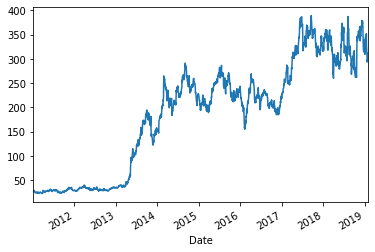

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = tsla['High']
vol.plot()

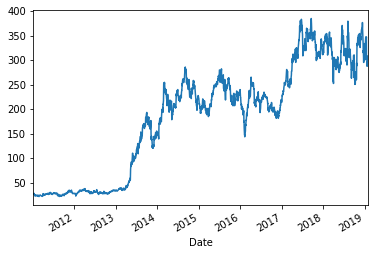

In [173]:
close = tsla['Close']
close.plot()

The plotting for 'High' and 'Close' values are quite similar. 

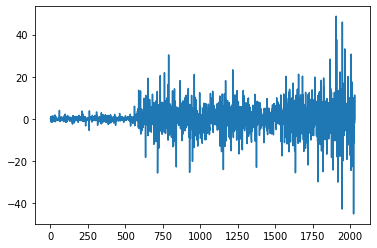

In [174]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

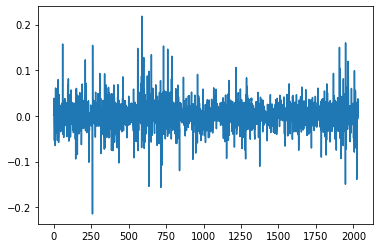

In [175]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [176]:
vol.corr(close)

0.9995887252653483

"0.99" shows really high correlation for the closing values for TESLA

Now performing exponential smoothening on the 'Close' price for the stock

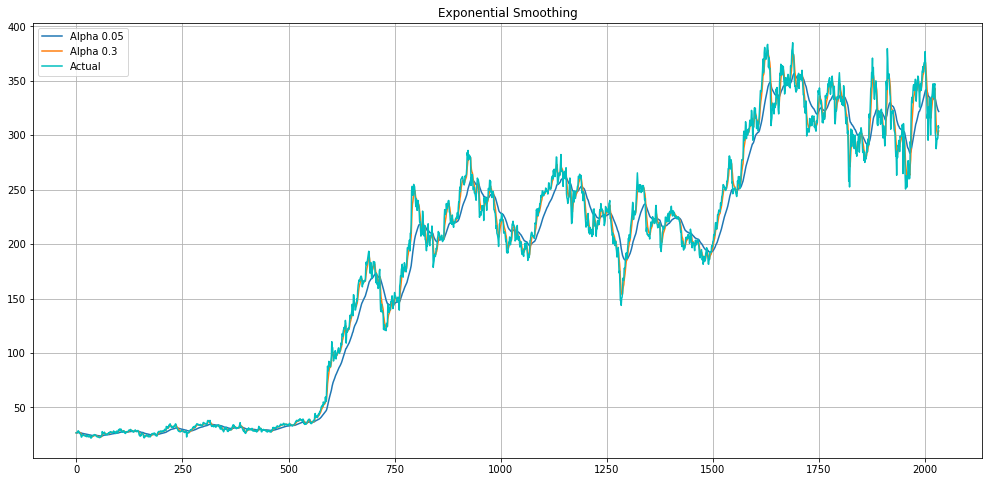

In [177]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(tsla.Close, [0.05, 0.3])

Exponential smoothing on the 'Close' prices of the stock shows a very closely running smoothened line graph with still quite a few steep changes over the period

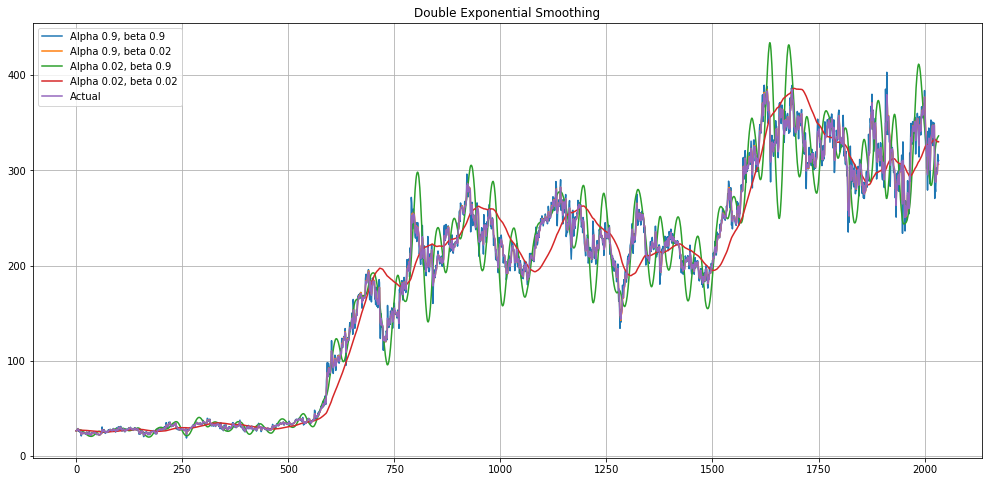

In [178]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(tsla.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

After performing Double Exponential smoothing, the line graph generated gives a much better idea about the trend of 'Close' values of the stock

Observing the plotting for single and double exponential smoothening, we can conclude that Tesla's closing stock is non-stationary. Implying, there are trends and patterns that can be extracted. 
Now, we'll check the stationarity using Dicky-Fuller Test.

DICKY-FULLER TEST :

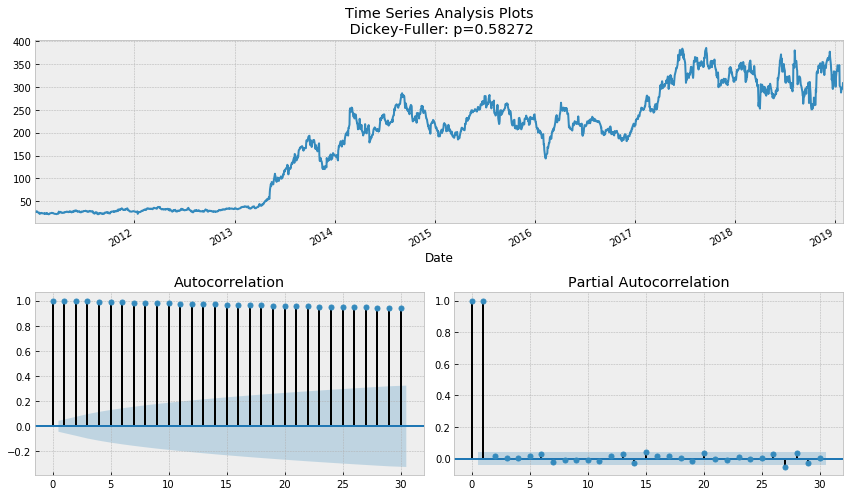

In [179]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(tsla.Close, lags=30)

By the Dickey-Fuller test, the time series is non-stationary.

Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference: We simply subtract the time series from itself with a lag of one day, and we get:

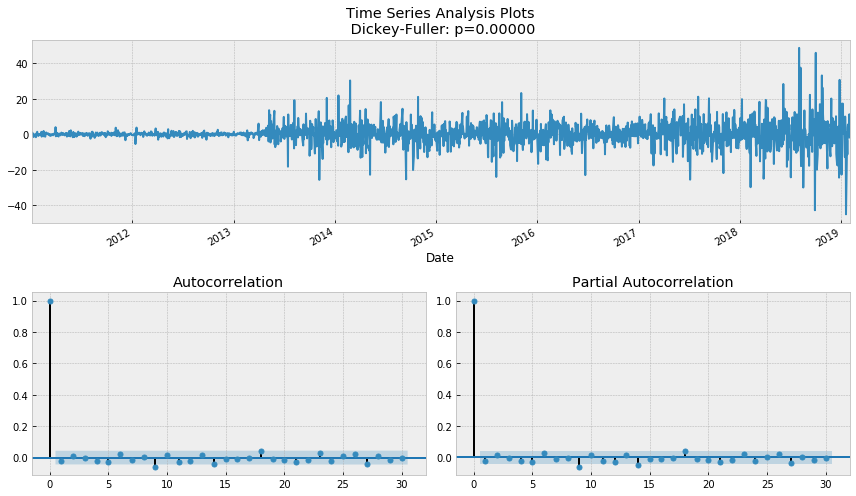

In [180]:
# Taking the first difference to remove to make the process stationary
data_diff = tsla.Close - tsla.Close.shift(1)

tsplot(data_diff[1:], lags=30)

Now, the closing price has been made stationary for modelling.

In [181]:
tsla.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,27.000000,25.900000,26.84,26.620001,1283000,26.620001
2011-01-04,26.950001,26.020000,26.66,26.670000,1187400,26.670000
2011-01-05,26.900000,26.190001,26.48,26.830000,1446700,26.830000
2011-01-06,28.000000,26.809999,26.83,27.879999,2061200,27.879999
2011-01-07,28.580000,27.900000,28.00,28.240000,2247900,28.240000


Now, we'll be making a custom dataframe that contains the values to be used for the stock prediction (High-Low percent change & percent change are some of the calculated values from the stock that will act as a strong independent variable for stock prediction)

In [197]:
dfreg = tsla.loc[:,['Adj Close', 'Volume']]
dfreg['HighLow_PCT'] = (tsla['High'] - tsla['Low']) / tsla['Close'] * 100.0
dfreg['PCT_change'] = (tsla['Close'] - tsla['Open']) / tsla['Open'] * 100.0
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change
Date,,,,
2011-01-03,26.620001,1283000,4.132233,-0.819670
2011-01-04,26.670000,1187400,3.487065,0.037510
2011-01-05,26.830000,1446700,2.646288,1.321754
2011-01-06,27.879999,2061200,4.268295,3.913527
2011-01-07,28.240000,2247900,2.407933,0.857142
...,...,...,...,...
2019-01-25,297.040009,7249600,3.019796,0.900164
2019-01-28,296.380005,6423300,3.276197,1.184665
2019-01-29,297.459991,4621700,2.272578,0.741695


We will be using 'Adj Close' values of our stock and predict it's values for our prediction

In [198]:
dfreg.fillna(value=-99999, inplace=True)

Using 15% of the data to forecast stocks for Tesla as per the data collected from 2011-2019

In [241]:
import math
forecast = int(math.ceil(0.15 * len(dfreg)))
forecast

305

According to the calulated value, this case being 305, we will be going back 305 days from the last day of stock for the prediction.
For prediction, we will be predicting 'Adjacent close' data for the stock

In [275]:
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast)
X = np.array(dfreg.drop(['label'], 1))
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2011-01-03,26.620001,1283000,4.132233,-0.819670,34.959999
2011-01-04,26.670000,1187400,3.487065,0.037510,35.150002
2011-01-05,26.830000,1446700,2.646288,1.321754,34.400002
2011-01-06,27.879999,2061200,4.268295,3.913527,34.080002
2011-01-07,28.240000,2247900,2.407933,0.857142,37.400002
...,...,...,...,...,...
2019-01-25,297.040009,7249600,3.019796,0.900164,NaN
2019-01-28,296.380005,6423300,3.276197,1.184665,NaN
2019-01-29,297.459991,4621700,2.272578,0.741695,NaN


In [270]:
dfreg.tail(306)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2017-11-10,302.989990,4625400,2.148579,0.161980,307.019989
2017-11-13,315.399994,7584900,5.608752,5.087792,NaN
2017-11-14,308.700012,5676100,3.061228,-1.999996,NaN
2017-11-15,311.299988,5978700,3.530354,1.728694,NaN
2017-11-16,312.500000,5822100,2.188809,-0.474534,NaN
...,...,...,...,...,...
2019-01-25,297.040009,7249600,3.019796,0.900164,NaN
2019-01-28,296.380005,6423300,3.276197,1.184665,NaN
2019-01-29,297.459991,4621700,2.272578,0.741695,NaN


The 'label' column of the dataframe is a copy of a shifted 'Adjusted Close' values. As the dataframe above shows, the column has been shifted to '2017-11-10' and hence the stock predictions will be done from that date. 

Scaling the 'X' for equal distribution during the linear regression

In [244]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [276]:
X_lately = X[-forecast:]
X = X[:-forecast]
X

array([[ 2.66200008e+01,  1.28300000e+06,  4.13223271e+00,
        -8.19669568e-01],
       [ 2.66700001e+01,  1.18740000e+06,  3.48706525e+00,
         3.75102361e-02],
       [ 2.68299999e+01,  1.44670000e+06,  2.64628806e+00,
         1.32175373e+00],
       ...,
       [ 3.04390015e+02,  4.72530000e+06,  1.83646854e+00,
        -3.63333994e-01],
       [ 3.02989990e+02,  5.44710000e+06,  2.69315949e+00,
         1.61980243e-01],
       [ 3.02989990e+02,  4.62540000e+06,  2.14857898e+00,
         1.61980243e-01]])

In [314]:
import numpy as np
y = np.array(dfreg['label'])
y
y = y[:-forecast]
y

array([ 34.95999908,  35.15000153,  34.40000153, ..., 297.45999146,
       308.76998901, 307.01998901])

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor()

In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [249]:
rf_model.fit(X_train, y_train)

C:\Users\rachc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [250]:
rf_model.score(X_test, y_test)

0.7097424026260659

We have predicted values for the stock to 70% accuracy, hence the ideal date to start our prediction for the stock is from 2017-11-10. Approximately a year & 2 months.

In [304]:
type(y_test)

numpy.ndarray

In [55]:
forecast_set = rf_model.predict(X_lately)
print(forecast_set)

[316.08999939 294.11699524 304.92800598 325.10400085 337.83800049
 320.68299866 314.76100159 317.7519928 ]
